In [24]:
import os
import torch
from PIL import Image, ImageTk
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import clip
import matplotlib.pyplot as plt
import torch.nn.functional as F


def preprocess(image):
    transform = Compose([
        Resize(224, interpolation=3),
        CenterCrop(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(image)


def preprocess_images(image_paths, model, device):
    image_features = []
    for path in image_paths:
        image = Image.open(path).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model.encode_image(image_tensor)
        features = features.flatten()
        image_features.append(features.cpu().numpy())
    return np.stack(image_features)


def search(query, image_paths, model, device):
    text = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text)
        image_features = preprocess_images(image_paths, model, device)

        if not isinstance(text_features, torch.Tensor):
            text_features = torch.from_numpy(text_features).to(device)
        if not isinstance(image_features, torch.Tensor):
            image_features = torch.from_numpy(image_features).to(device)
        cosine_similarity = F.cosine_similarity(text_features, image_features, dim=-1)
        
    values, indices = cosine_similarity.topk(5)
    results = [(image_paths[idx], values[i].item()) for i, idx in enumerate(indices)]
    return results


model, preprocess = clip.load('ViT-B/32', device='cpu')

In [25]:
def plot_results(results):
    for image_path, score in results:
        # Load the image using PIL
        img = Image.open(image_path)

        # Plot the image
        plt.imshow(img)
        plt.title(f'Similarity Score: {score:.4f}')
        plt.axis('off')
        plt.show()

In [26]:
image_paths = [os.path.join("images/", filename) for filename in os.listdir("images/") if filename.endswith((".jpg",".png"))]

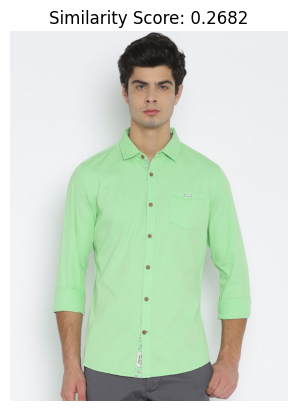

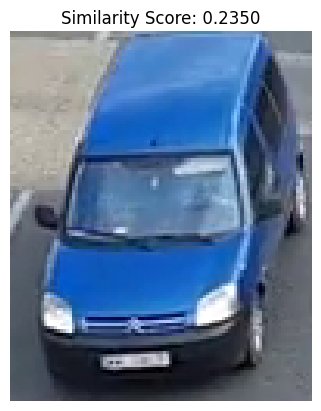

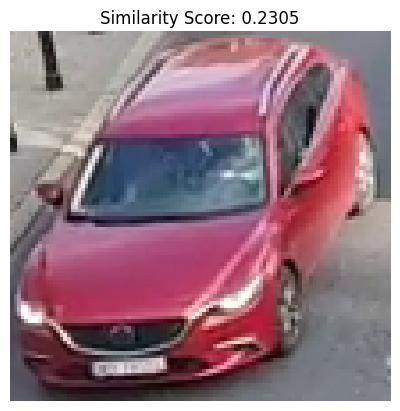

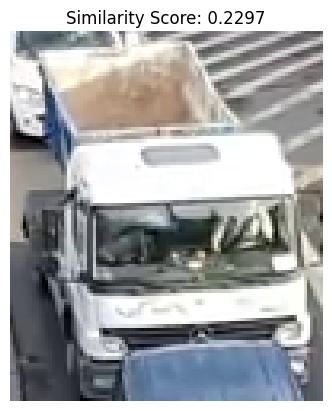

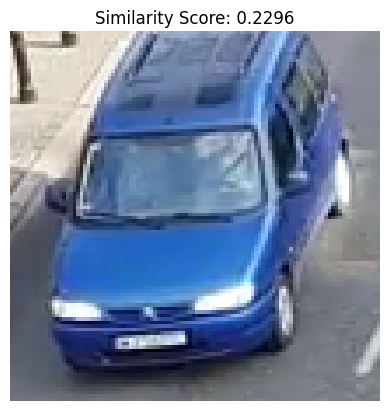

In [27]:
results = search("green human", image_paths, model, "cpu")
plot_results(results)

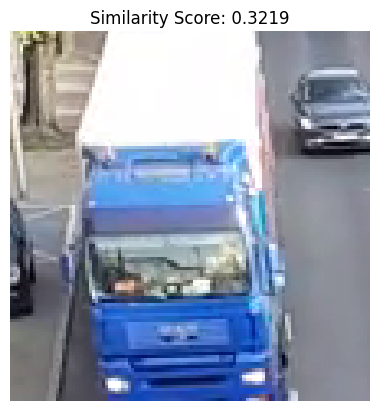

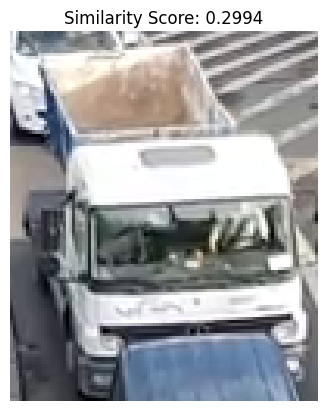

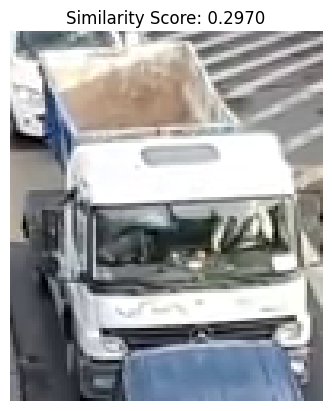

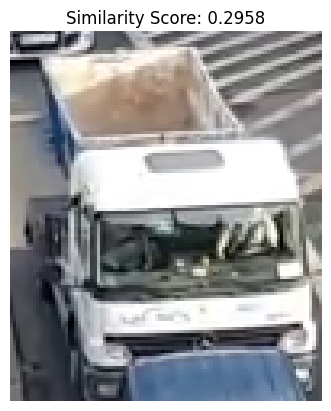

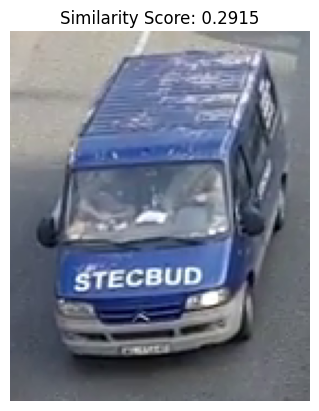

In [28]:
results = search("blue truck", image_paths, model, "cpu")
plot_results(results)

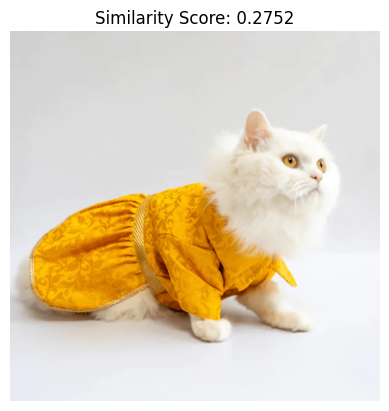

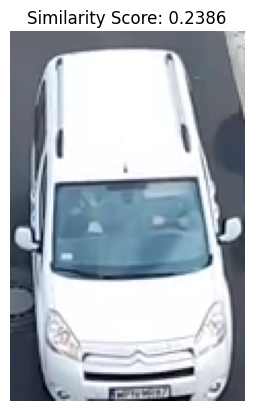

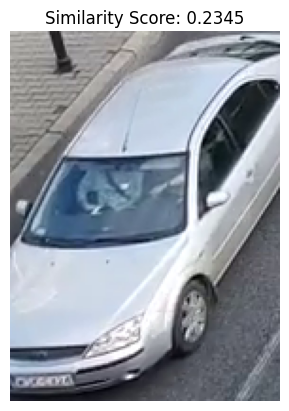

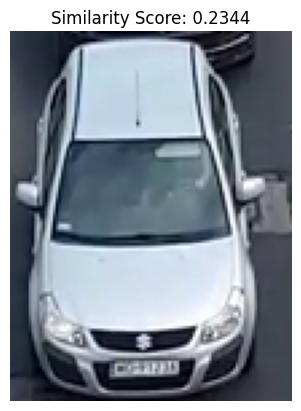

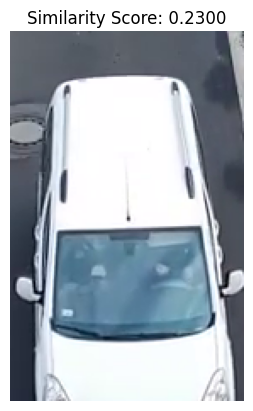

In [29]:
results = search("cat", image_paths, model, "cpu")
plot_results(results)